# NER tagging

This project aims to implement a NER Tagger with Pytorch. We will be using the English CONLL 2003 data set.

Data download & description
--------

In [ ]:
from urllib.request import urlretrieve
urlretrieve('https://raw.githubusercontent.com/pranabsarkar/Conll_task/master/conll-2003/eng.train','eng.train')
urlretrieve('https://raw.githubusercontent.com/pranabsarkar/Conll_task/master/conll-2003/eng.testa','eng.testa')

#Prints the beginning of the training set
istream = open('eng.testa')
for idx, line in enumerate(istream):
  print(line.strip())
  if idx >=20:
    break
istream.close()

-DOCSTART- -X- -X- O

CRICKET NNP I-NP O
- : O O
LEICESTERSHIRE NNP I-NP I-ORG
TAKE NNP I-NP O
OVER IN I-PP O
AT NNP I-NP O
TOP NNP I-NP O
AFTER NNP I-NP O
INNINGS NNP I-NP O
VICTORY NN I-NP O
. . O O

LONDON NNP I-NP I-LOC
1996-08-30 CD I-NP O

West NNP I-NP I-MISC
Indian NNP I-NP I-MISC
all-rounder NN I-NP O
Phil NNP I-NP I-PER


The CONLL 2003 dataset encodes each token on a single line followed by its annotation. A token line is a quadruple:

> (token,tag,chunk,named entity)

A named entity tagger aims to predict the named entity annotations given the raw tokens. The NER tags follows the IOB convention.
* **I** stands for **Inside** and is used to flag tokens that are part of a named entity.
* **B** stands for **Begin** and is used to flag a token starting a new entity when the preceding token is already part of an entity.
* **O** stands for **Outside** and is used to flag tokens that are not part of a named entity.

The I and B Tag are followed by a specifier. For instance I-PER means that the named entity refers to a person, I-ORG means that the entity is refers to an Organisation.

Sentences are separated by a blank line. The train file is `eng.train`, the dev file is `eng.testa`. I will evaluate your work with a test file unknown to you.
To do this, I will change the content of the dev file



# 1. Data preprocessing
---


Using CONLL2003 the train file, we will:

* Extract an input vocabulary and create two maps: one mapping tokens to integers and a second mapping integers to tokens (see the pdf notes)
* Include elements in the input vocabulary for padding and for unknown words
* Extract an output vocabulary (the set of NER tags) and returns two maps
mapping tags to integer and vice-versa.


In [ ]:
def vocabulary(filename,input_vocab,padding='<pad>',unknown='<unk>'):
    #input_vocab is a boolean flag that tells if we extract input or output vocabulary
    #the two optional flags indicate that a padding and an unknown token
    #have to be added to the vocabulary if their value is not None

    idx2sym = set()
    sym2idx = {}
    i = 0

    with open(filename, 'r') as f:
      lines = [line.strip().split(" ") for line in f.readlines() if line.strip() != ""]

      # Filling both vocabulary based on the input_vocab value
      if input_vocab:
        for line in lines :
          idx2sym.add(line[0])
        idx2sym = list(idx2sym)
        sym2idx = {token: index for index, token in enumerate(idx2sym)}
        # Adding a padding and an unknown token if their value is not None
        if padding:
            idx2sym.append(padding)
            sym2idx[padding]=len(idx2sym)-1
        if unknown:
            idx2sym.append(unknown)
            sym2idx[unknown]=len(idx2sym)-1

      else :
        for line in lines :
          idx2sym.add(line[-1])
        idx2sym = list(idx2sym)
        sym2idx = {token: index for index, token in enumerate(idx2sym)}
        if padding:
            idx2sym.append(padding)
            sym2idx[padding]=len(idx2sym)-1

    return idx2sym, sym2idx

In [ ]:
## Test
input_vocab_idx2sym, input_vocab_sym2idx = vocabulary('eng.testa', input_vocab=True, padding='<pad>',unknown='<unk>')
output_vocab_idx2sym, output_vocab_sym2idx = vocabulary('eng.testa', input_vocab=False, padding='<pad>',unknown='<unk>')
print(output_vocab_sym2idx)

{'I-LOC': 0, 'O': 1, 'I-ORG': 2, 'I-PER': 3, 'B-MISC': 4, 'I-MISC': 5, '<pad>': 6}


Now we implement three functions:

* One that performs padding
* The second will encode a sequence of tokens (or a sequence of tags) on integers
* The third will decode as sequence of symbols from integers to strings


In [ ]:
def pad_sequence(sequence,pad_size,pad_token):
    #returns a list with additional pad tokens if needed
    while len(sequence) < pad_size:
      sequence.append(pad_token)
    return sequence

def code_sequence(sequence,coding_map,unk_token=None):
    #takes a list of strings and returns a list of integers
    encoded_sequence = []
    if unk_token:
        return [coding_map[w]  if w in coding_map else coding_map[unk_token] for w in sequence ]
    return [coding_map[w] for w in sequence if w in coding_map]

def decode_sequence(sequence,decoding_map):
    #takes a list of integers and returns a list of strings
    decoded_sequence = [decoding_map[idx] for idx in sequence]
    return decoded_sequence

In [ ]:
## Test
# Load data from the dataset
with open('eng.train', 'r') as train_file:
    train_data = [line.strip().split() for line in train_file if line.strip()]

# Extract a sequence of tokens or tags from the dataset
sample_sequence = [line[0] for line in train_data]  # Is this what is understood by sequence?

# Pad the sequence
padded_sequence = pad_sequence(sample_sequence, pad_size=10, pad_token='<pad>')

# Encode the sequence to integers
encoded_sequence = code_sequence(sample_sequence, input_vocab_sym2idx, unk_token='<unk>')

# Decode the sequence back to strings
decoded_sequence = decode_sequence(encoded_sequence, input_vocab_idx2sym)

# 2. Data generator
------

We will write a mini-batch generator. This is a class in charge of generating randomized batches of data from the dataset. We start by implementing two functions for reading the textfile


In [ ]:
def read_conll_tokens(conllfilename):
    """
    Reads a CONLL 2003 file and returns a list of sentences.
    A sentence is a list of strings (tokens)
    """
    sentences = []
    with open(conllfilename, 'r') as file:
        current_sentence = []
        for line in file:
            line = line.strip()
            if line:
                parts = line.split()
                current_sentence.append(parts[0])  # Token is the first element
            else: # if the line is empty, the sentence is complete
                if current_sentence:
                    sentences.append(current_sentence)
                current_sentence = []
        if current_sentence:  # Handle the last sentence
            sentences.append(current_sentence)
    return sentences

def read_conll_tags(conllfilename):
    """
    Reads a CONLL 2003 file and returns a list of sentences.
    A sentence is a list of strings (NER-tags)
    """
    sentences = []
    with open(conllfilename, 'r') as file:
        current_sentence = []
        for line in file:
            line = line.strip()
            if line:
                parts = line.split()
                current_sentence.append(parts[3])  # NER-Tag is the fourth column
            else:
                if current_sentence:
                    sentences.append(current_sentence)
                current_sentence = []
        if current_sentence:
            sentences.append(current_sentence)
    return sentences

In [ ]:
## Test
# Read tokens and NER tags from the dataset
tokens_sentences = read_conll_tokens("eng.testa")
tags_sentences = read_conll_tags("eng.testa")

# Print the first few sentences for tokens and NER tags
for i in range(5):
    print(f"Sentence {i + 1} - Tokens: {tokens_sentences[i]}")
    print(f"Sentence {i + 1} - NER Tags: {tags_sentences[i]}")
    print()

Sentence 1 - Tokens: ['-DOCSTART-']
Sentence 1 - NER Tags: ['O']

Sentence 2 - Tokens: ['CRICKET', '-', 'LEICESTERSHIRE', 'TAKE', 'OVER', 'AT', 'TOP', 'AFTER', 'INNINGS', 'VICTORY', '.']
Sentence 2 - NER Tags: ['O', 'O', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Sentence 3 - Tokens: ['LONDON', '1996-08-30']
Sentence 3 - NER Tags: ['I-LOC', 'O']

Sentence 4 - Tokens: ['West', 'Indian', 'all-rounder', 'Phil', 'Simmons', 'took', 'four', 'for', '38', 'on', 'Friday', 'as', 'Leicestershire', 'beat', 'Somerset', 'by', 'an', 'innings', 'and', '39', 'runs', 'in', 'two', 'days', 'to', 'take', 'over', 'at', 'the', 'head', 'of', 'the', 'county', 'championship', '.']
Sentence 4 - NER Tags: ['I-MISC', 'I-MISC', 'O', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-ORG', 'O', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Sentence 5 - Tokens: ['Their', 'stay', 'on', 'top', ',', 'though', ',', 'may', 'be', 'short-lived', 'as



Now we implement the class.

In [ ]:
import torch
import torch.nn as nn
from random import shuffle

class DataGenerator:

        #Reuse all relevant helper functions defined above to solve the problems
        def __init__(self,conllfilename, parentgenerator = None, pad_token='<pad>',unk_token='<unk>', pos=False):
              """
                conllfilename: String | indicates the path to the file
                parentgenerator: DataGenerator
                pad_token: String | token used to pad sequences
                unk_token: String | token used for unknown words
                pos: Boolean | indicates if pos embeddings should be generated
              """
              self.pos=pos
              if parentgenerator is not None: #Reuse the encodings of the parent if specified
                  self.pad_token      = parentgenerator.pad_token
                  self.unk_token      = parentgenerator.unk_token
                  self.input_sym2idx  = parentgenerator.input_sym2idx
                  self.input_idx2sym  = parentgenerator.input_idx2sym
                  self.output_sym2idx = parentgenerator.output_sym2idx
                  self.output_idx2sym = parentgenerator.output_idx2sym

                  if self.pos:
                    self.pos_sym2idx = parentgenerator.pos_sym2idx
                    self.pos_idx2sym = parentgenerator.pos_idx2sym


              else:                           #Creates new encodings
                  self.pad_token = pad_token
                  self.unk_token = unk_token
                  # Create 4 encoding maps from datafile
                  self.input_idx2sym,self.input_sym2idx   = vocabulary('eng.train', input_vocab=True, padding= self.pad_token,unknown=self.unk_token)
                  self.output_idx2sym,self.output_sym2idx = vocabulary('eng.train', input_vocab=False, padding=self.pad_token,unknown=self.unk_token)
                  if self.pos:
                    self.pos_idx2sym, self.pos_sym2idx = get_pos_vocab('eng.train',padding=self.pad_token,unknown=self.unk_token)



              # Store the conll dataset with sentence structure (a list of lists of strings) in the following fields
              self.Xtokens = read_conll_tokens(conllfilename)
              self.Ytokens = read_conll_tags(conllfilename)
              if self.pos:
                self.Ptags = read_conll_pos(conllfilename)


        def generate_batches(self,batch_size):
              #This is an example generator function yielding one batch after another
              #Batches are lists of lists

              assert(len(self.Xtokens) == len(self.Ytokens))

              N     = len(self.Xtokens)
              idxes = list(range(N))

              #Data ordering (try to explain why these 2 lines make sense...)
              shuffle(idxes)
              idxes.sort(key=lambda idx: len(self.Xtokens[idx]))

              #batch generation
              bstart = 0
              while bstart < N:
                 bend        = min(bstart+batch_size,N)
                 batch_idxes = idxes[bstart:bend]
                 batch_len   = max(len(self.Xtokens[idx]) for idx in batch_idxes)

                 seqX = [ pad_sequence(self.Xtokens[idx],batch_len,self.pad_token) for idx in batch_idxes]
                 seqY = [ pad_sequence(self.Ytokens[idx],batch_len,self.pad_token) for idx in batch_idxes]
                 seqX = [ code_sequence(seq,self.input_sym2idx,self.unk_token) for seq in seqX]
                 seqY = [ code_sequence(seq,self.output_sym2idx) for seq in seqY]

                 if self.pos:
                  seqP = [pad_sequence(self.Ptags[idx], batch_len, self.pad_token) for idx in batch_idxes]
                  seqP = [code_sequence(seq, self.pos_sym2idx, self.unk_token) for seq in seqP]


                 assert(len(seqX) == len(seqY))

                 if self.pos:
                  yield (seqX,seqY,seqP)
                 else:
                  yield (seqX,seqY)

                 bstart += batch_size

# 3. Implement the tagger
---------------
There are three main tasks:
* Implement parameter allocation. This implies allocating the embedding layer, the LSTM (or bi-LSTM) layer and the Linear Layer.
* Implement the forward method. This method expects a tensor encoding the input and outputs a tensor of predictions
* Implement the train method


In [ ]:
# Function used for a further assignment: implementing an attention layer
def batched_attention(Q, K, V):
    """
    Batched version of the previous one.
    Expects a 3rd order tensor of the form
    [batch_size, seq_length, emb_size]
    """
    # bmm (batch matrix multiplication)
    # transpose is batched transposition
    softmax = nn.Softmax(dim=2)
    # If input is a (b×n×m)(b×n×m) tensor, mat2 is a (b×m×p)(b×m×p) tensor, out will be a (b×n×p)(b×n×p) tensor

    return torch.bmm(softmax(torch.bmm(Q, torch.transpose(K, 2, 1))), V)

In [ ]:
import torch.optim as optim

class NERtagger(nn.Module):

      def __init__(self,traingenerator, embedding_size, hidden_size, pos_embedding_size=None,device='cpu',early_stopping_patience=5, dropout_prob=0.5,improvements=[]):
        """
        Initialize the NERtagger.

        Args:
            traingenerator (DataGenerator): The data generator.
            embedding_size (int): Size of word embeddings.
            hidden_size (int): Size of the hidden LSTM layer.
            pos_embedding_size (int, optional): Size of POS embeddings. Default is None.
            device (str, optional): Device for computation. Default is 'cpu'.
            early_stopping_patience (int, optional): Patience for early stopping. Default is 5.
            dropout_prob (float, optional): Probability for dropout. Default is 0.5.
            improvements (list, optional): List of possible improvements implemented (pos, attention, pretrained).

        """
        super(NERtagger, self).__init__()
        self.embedding_size    = embedding_size
        self.hidden_size       = hidden_size
        self.dropout_prob=dropout_prob
        self.improvements=improvements
        self.pos_embedding_size=pos_embedding_size

        if "pretrained" in improvements:
          self.allocate_params(traingenerator,device,create_embedding_matrix(traingenerator.input_sym2idx,300))
        else:
          self.allocate_params(traingenerator,device)

        self.early_stopping_patience= early_stopping_patience

      def load(self,filename):
        self.load_state_dict(torch.load(filename))

      def allocate_params(self,datagenerator,device, embeddings=None):
        # Create fields for nn Layers
        vocab_size = len(datagenerator.input_idx2sym)
        if embeddings !=None:
          self.embedding=torch.nn.Embedding.from_pretrained(embeddings, freeze=True, padding_idx=None).to(device)
        else:
          self.embedding = nn.Embedding(vocab_size, self.embedding_size)

        if "pos" in self.improvements:
          pos_vocab_size = len(datagenerator.pos_idx2sym)
          self.pos_embedding = nn.Embedding(pos_vocab_size, self.pos_embedding_size)
          self.lstm = nn.LSTM(self.embedding_size+self.pos_embedding_size, self.hidden_size, batch_first=True, bidirectional=True)
        else:
          self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, batch_first=True, bidirectional=True)

        self.dropout= nn.Dropout(p=self.dropout_prob)
        self.linear = nn.Linear(self.hidden_size *2, len(datagenerator.output_idx2sym))

      def forward(self,Xinput,pos_input=None):
        """
        Forward pass for the NERtagger.

        Args:
            Xinput (torch.Tensor): Input tensor of shape [batch_size, seq_length].
            pos_input (torch.Tensor, optional): Input tensor for POS tags. Default is None.

        Returns:
            torch.Tensor: Predicted output tensor.
        """
        # Prediction steps
        embedded = self.embedding(Xinput).float()
        if "pos" in self.improvements:
          pos_embedded = self.pos_embedding(pos_input)
          embedded = torch.cat((embedded, pos_embedded), dim=2)

        if "attention" in self.improvements:
          embedded= batched_attention(embedded, embedded, embedded)

        # Pass the output through LSTM
        output, _ = self.lstm(embedded)
        output=self.dropout(output)
        predictions = self.linear(output)
        return predictions

      def training_loop(self,traingenerator,validgenerator,epochs,batch_size,device='cpu',learning_rate=0.001):
        """
        Training loop of the NERtagger.

        Args:
          traingenerator : instance of DataGenerator
          validgenerator: instance of DataGenerator
          epochs: int | number of epochs
          batch_size: int | number of examples in each batch
          device: Device for computation. Default is 'cpu'.
          learning_rate: float | Default is 0.001
        """
        self.minloss = 10000000 #the min loss found so far on validation data
        device = torch.device(device)
        self.to(device)
        no_improvement_counter =0
        res = {"train_losses": [], "val_losses": [], "train_accuracies": [], "val_accuracies": []}

        # Define the loss function and optimizer
        pad_index = traingenerator.input_sym2idx[traingenerator.pad_token]
        loss_func = nn.CrossEntropyLoss (ignore_index=pad_index)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        best_valid_loss = self.minloss
        for epoch in range(epochs):
          self.train()
          batch_losses = []
          if "pos" in self.improvements:
            for (seqX, seqY, seqP) in traingenerator.generate_batches(batch_size):
                X = torch.LongTensor(seqX).to(device)
                Y = torch.LongTensor(seqY).to(device)
                P = torch.LongTensor(seqP).to(device)  # POS tag input
                optimizer.zero_grad()
                Yhat = self.forward(X, P)
                # Flattening and loss computation
                batch_size, seq_len, _ = Yhat.shape
                Yhat = Yhat.view(batch_size * seq_len, -1)
                Y = Y.view(batch_size * seq_len)
                loss = loss_func(Yhat, Y)
                loss.backward()
                optimizer.step()
                batch_losses.append(loss.item())
          else:
            for (seqX, seqY) in traingenerator.generate_batches(batch_size):
              X = torch.LongTensor(seqX).to(device)
              Y = torch.LongTensor(seqY).to(device)
              optimizer.zero_grad()
              Yhat = self.forward(X)

              # Flattening and loss computation
              batch_size, seq_len, _ = Yhat.shape
              Yhat = Yhat.view(batch_size * seq_len, -1)
              Y = Y.view(batch_size * seq_len)
              loss = loss_func(Yhat, Y)
              loss.backward()
              optimizer.step()
              batch_losses.append(loss.item())

          L = len(batch_losses)
          train_loss = sum(batch_losses) / L
          print(f'Epoch {epoch + 1}')
          #Validation on train
          train_loss, train_acc = self.validate(traingenerator, batch_size, "train", device)

          # Validation
          self.eval()
          valid_loss, valid_acc = self.validate(validgenerator, batch_size, "dev", device)
          res["train_losses"].append(train_loss)
          res["train_accuracies"].append(train_acc)
          res["val_losses"].append(valid_loss)
          res["val_accuracies"].append(valid_acc)

          # Check for early stopping
          if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              no_improvement_counter = 0
          else:
              no_improvement_counter += 1

          if no_improvement_counter >= self.early_stopping_patience:
              print("Early stopping. No improvement for the last {} epochs.".format(self.early_stopping_patience))
              return res, valid_acc

          # Save the model if it's the best so far
          if valid_loss < self.minloss:
              self.minloss = valid_loss
              torch.save(self.state_dict(), 'tagger_params.pt')

        return res, valid_acc


      def validate(self,datagenerator,batch_size, set_type, device='cpu',save_min_model=False):
          batch_accurracies = []
          batch_losses      = []

          device = torch.device(device)
          pad_index = datagenerator.output_sym2idx[datagenerator.pad_token]
          loss_fnc  = nn.CrossEntropyLoss(ignore_index=pad_index)

          if "pos" in self.improvements:
            for (seqX, seqY, seqP) in datagenerator.generate_batches(batch_size):
              with torch.no_grad():
                X = torch.LongTensor(seqX).to(device)
                Y = torch.LongTensor(seqY).to(device)
                P = torch.LongTensor(seqP).to(device)  # POS tag input

                Yhat = self.forward(X, P)
                #Flattening and loss computation
                batch_size,seq_len = Y.shape
                Yhat = Yhat.view(batch_size*seq_len,-1)
                Y    = Y.view(batch_size*seq_len)
                loss = loss_fnc(Yhat,Y)
                batch_losses.append(loss.item())

                #Accurracy computation
                mask    = (Y != pad_index)
                Yargmax = torch.argmax(Yhat,dim=1)
                correct = torch.sum((Yargmax == Y) * mask)
                total   = torch.sum(mask)
                batch_accurracies.append(float(correct)/float(total))
          else:
            for (seqX,seqY) in datagenerator.generate_batches(batch_size):
                  with torch.no_grad():
                    X = torch.LongTensor(seqX).to(device)
                    Y = torch.LongTensor(seqY).to(device)

                    Yhat = self.forward(X)

                    #Flattening and loss computation
                    batch_size,seq_len = Y.shape
                    Yhat = Yhat.view(batch_size*seq_len,-1)
                    Y    = Y.view(batch_size*seq_len)
                    loss = loss_fnc(Yhat,Y)
                    batch_losses.append(loss.item())

                    #Accurracy computation
                    mask    = (Y != pad_index)
                    Yargmax = torch.argmax(Yhat,dim=1)
                    correct = torch.sum((Yargmax == Y) * mask)
                    total   = torch.sum(mask)
                    batch_accurracies.append(float(correct)/float(total))

          L = len(batch_losses)
          valid_loss = sum(batch_losses)/L

          if save_min_model and valid_loss < self.minloss and set_type == "dev":
            self.minloss = valid_loss
            torch.save(self.state_dict(), 'tagger_params.pt')

          print(f'[{set_type}] mean Loss = %f | mean accurracy = %f'%(valid_loss,sum(batch_accurracies)/L))

          return valid_loss, sum(batch_accurracies)/L

In [ ]:
import matplotlib.pyplot as plt

def plot_train_val_res(res):
    # Function that plots the results of a training

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(res["train_losses"], label="Training Loss")
    plt.plot(res["val_losses"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Evolution of the average loss regarding the epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(res["train_accuracies"], label='Training Accuracy')
    plt.plot(res["val_accuracies"], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Evolution of the accuracies regarding the epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

Main program

Epoch 1
[train] mean Loss = 0.518912 | mean accurracy = 0.841660
[dev] mean Loss = 0.551807 | mean accurracy = 0.838541
Epoch 2
[train] mean Loss = 0.275927 | mean accurracy = 0.916129
[dev] mean Loss = 0.415848 | mean accurracy = 0.891770
Epoch 3
[train] mean Loss = 0.155852 | mean accurracy = 0.952498
[dev] mean Loss = 0.372878 | mean accurracy = 0.919155
Epoch 4
[train] mean Loss = 0.099065 | mean accurracy = 0.969389
[dev] mean Loss = 0.355073 | mean accurracy = 0.931005
Epoch 5
[train] mean Loss = 0.068717 | mean accurracy = 0.978701
[dev] mean Loss = 0.362899 | mean accurracy = 0.935500
Epoch 6
[train] mean Loss = 0.042590 | mean accurracy = 0.986305
[dev] mean Loss = 0.358898 | mean accurracy = 0.943029
Epoch 7
[train] mean Loss = 0.032325 | mean accurracy = 0.989342
[dev] mean Loss = 0.389198 | mean accurracy = 0.943756
Epoch 8
[train] mean Loss = 0.018969 | mean accurracy = 0.993903
[dev] mean Loss = 0.416618 | mean accurracy = 0.949347
Epoch 9
[train] mean Loss = 0.013967 | m

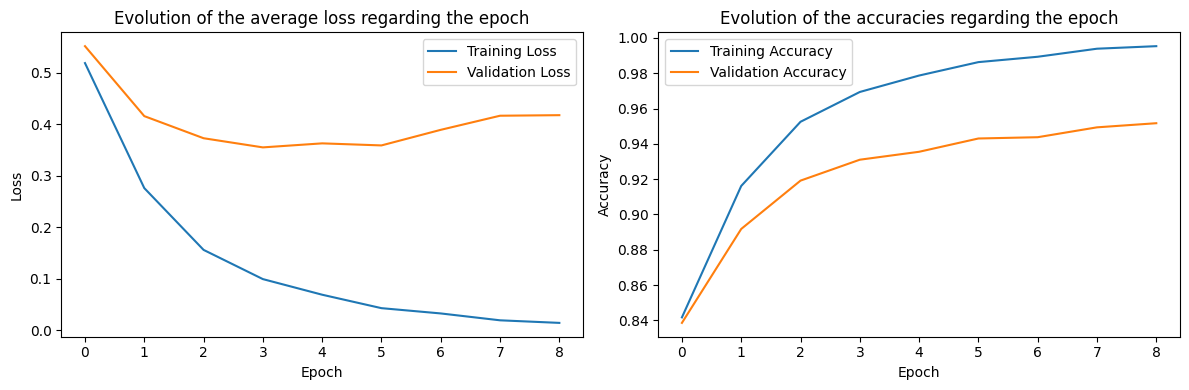

In [ ]:
## First training with initial parameters
trainset = DataGenerator('eng.train')
validset = DataGenerator('eng.testa',parentgenerator = trainset)
tagger   = NERtagger(traingenerator=trainset, embedding_size=64, hidden_size=128,device='cuda', early_stopping_patience=5, dropout_prob = 0.5)
res, valid_acc = tagger.training_loop(trainset,validset,20,32,device='cuda')
plot_train_val_res(res)

# 4. Grid Search

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from itertools import product
from tqdm import tqdm

search_space={
    'learning_rate': [0.001,0.0001, 0.00001],
    'batch_size':[16,64, 128],
    'embedding_size':[50,150],
    'hidden_size': [50, 100, 200],
    'dropout_prob' : [0, 0.1, 0.5]
}

configuration_accuracies= {}

config_combinations= list(product(*search_space.values()))
nb_configs=len(list(config_combinations))
print(f"The total number of configurations is {nb_configs}")

config_id=1
nb_epochs=10

with tqdm(total=nb_configs,desc='Computing Gridsearch') as pbar:
  for config in config_combinations:
    learning_rate,batch_size,embedding_size,hidden_size, dropout_prob= config
    print(f"\nconfig: learning_rate:{learning_rate},batch_size:{batch_size},embedding_size:{embedding_size}, hidden_size: {hidden_size}, dropout_prob: {dropout_prob}")
    model= NERtagger(traingenerator=trainset,embedding_size= embedding_size,hidden_size= hidden_size, dropout_prob= dropout_prob, device='cuda')
    _,valid_acc=model.training_loop(traingenerator=trainset,validgenerator=validset, epochs=nb_epochs, batch_size= batch_size, learning_rate=learning_rate, device='cuda')

    min_loss=model.minloss

    print(f"Min loss on configuration {config_id}/{nb_configs} is {min_loss}, accuracy on dev is {valid_acc}")

    with open('/content/drive/MyDrive/ML for NLP3/TPs Crabbé/GridSearch.tsv','a') as file:   # /content/drive/MyDrive/TP4/GridSearch.tsv
        file.write(f"{learning_rate}\t{batch_size}\t{embedding_size}\t{hidden_size}\t{dropout_prob}\t{min_loss}\t{valid_acc}\n")

    config_id+=1
    pbar.update(1)


## Plotting and interpreting the hyperparameter search:


1.   Plotting the mean accuracy and standard derivation per hyperparameter
2.   Interpreting and commenting on the plots and propose further possible hyperparameters for a more detailed research



In [ ]:
# dowloading the configurations and corresponding accuracies from the grid search (path : /content/GridSearch.tsv)
!gdown --id 1Y1EkS0FRh-64K77FiPkan5psTwvYwFoC

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Y1EkS0FRh-64K77FiPkan5psTwvYwFoC
To: /content/GridSearch.tsv
100% 9.48k/9.48k [00:00<00:00, 29.5MB/s]


In [ ]:
import pandas as pd
import json
df = pd.read_csv("/content/GridSearch.tsv",
                 sep="\t",
                 names = ["learning rate", "batch size", "embedding size",  "hidden size", "dropout probability","min validation loss", "validation accuracy"])
idx = df['validation accuracy'].idxmax()  # selecting the row with the best accuracy
learning_rate, batch_size,embedding_size, hidden_size,dropout_prob,min_loss, valid_acc = df.loc[idx]
print(f"Best configuration of hyperparameters:\n\tlearning_rate: {learning_rate}\n\tbatch_size: {batch_size}\n\tembedding size: {embedding_size}\n\thidden layer: {hidden_size}\n\tdropout prob: {dropout_prob}\n\tloss: {min_loss},accuracy: {valid_acc}")  # hyperparameters returning the best accuracy

Best configuration of hyperparameters:
	learning_rate: 0.001
	batch_size: 64.0
	embedding size: 150.0
	hidden layer: 50.0
	dropout prob: 0.5
	loss: 0.2297289856215858,accuracy: 0.9593024331404632


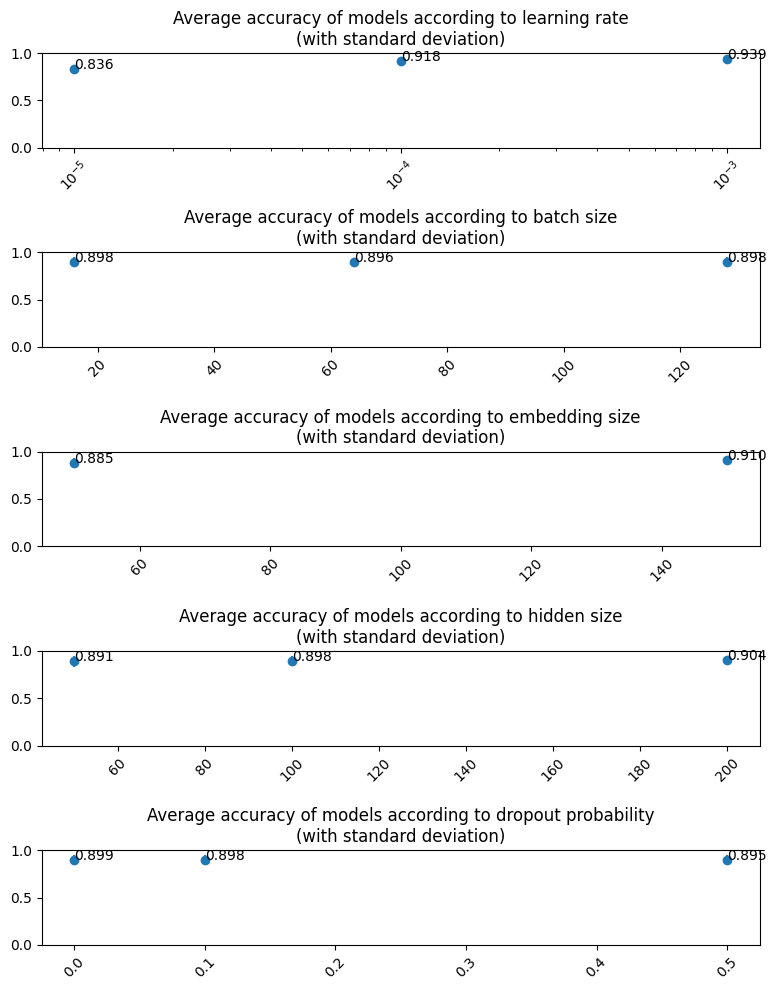

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define a list of hyperparameter types
hyperparameter_types = ["learning rate", "batch size", "embedding size", "hidden size", "dropout probability"]

# Create a grid of subplots
fig, axes = plt.subplots(len(hyperparameter_types), 1, figsize=(8, 10))

for i, hyperparameter_type in enumerate(hyperparameter_types):
    # Select the current subplot
    ax = axes[i]

    hyperparameter = [elt for elt in set(df[hyperparameter_type].tolist())]  # x-axis
    y = []  # y-axis
    std_devs = []  # Standard deviations

    for value in hyperparameter:
        # Retrieve mean accuracy for each hyperparameter
        temp_df = df.loc[df[hyperparameter_type] == value]
        mean_accuracy = temp_df["validation accuracy"].mean()
        y.append(mean_accuracy)

        # Calculate standard deviation
        std_dev = np.std(temp_df["validation accuracy"])
        std_devs.append(std_dev)

        ax.text(value, mean_accuracy, str(mean_accuracy)[:5])

    # Plot with error bars using standard deviations
    ax.errorbar(y=y, x=hyperparameter, yerr=std_devs, fmt='o')
    ax.set_title(f"Average accuracy of models according to {hyperparameter_type}\n(with standard deviation)")

    if hyperparameter_type in ["learning rate"]:
        ax.set_xscale("log")

    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, 1)

# Adjust the layout
plt.tight_layout()

# Show the grid of subplots
plt.show()

**Comment:**

These plots suggest that we might want to try a *bigger learning rate* (for example 0.01), a *larger hidden layer size* and eventually a *bigger embedding size*. As for batch size, we can see that there is no significant difference between the accuracies over the different tested values, but since computation is faster with a high embedding size, we might select the highest one for our model even though this is not the one used in the best configuration.


# 5. Improve the tagger
----------



==> All the following improvements can be used by passing them as a parameter of the original NERtagger within the "improvement" parameter as a list.

## Adding an attention layer

The following training implies changes in the NERtagger which are specified with the mention "attention".

Epoch 1
[train] mean Loss = 0.510889 | mean accurracy = 0.844139
[dev] mean Loss = 0.501518 | mean accurracy = 0.845376
Epoch 2
[train] mean Loss = 0.289547 | mean accurracy = 0.909146
[dev] mean Loss = 0.334837 | mean accurracy = 0.894552
Epoch 3
[train] mean Loss = 0.165623 | mean accurracy = 0.948028
[dev] mean Loss = 0.263342 | mean accurracy = 0.916669
Epoch 4
[train] mean Loss = 0.100273 | mean accurracy = 0.967733
[dev] mean Loss = 0.224683 | mean accurracy = 0.933547
Epoch 5
[train] mean Loss = 0.074232 | mean accurracy = 0.976238
[dev] mean Loss = 0.218097 | mean accurracy = 0.940336
Epoch 6
[train] mean Loss = 0.041762 | mean accurracy = 0.986683
[dev] mean Loss = 0.215192 | mean accurracy = 0.945296
Epoch 7
[train] mean Loss = 0.027412 | mean accurracy = 0.991140
[dev] mean Loss = 0.239067 | mean accurracy = 0.946742
Epoch 8
[train] mean Loss = 0.022287 | mean accurracy = 0.992797
[dev] mean Loss = 0.246665 | mean accurracy = 0.951771
Epoch 9
[train] mean Loss = 0.014882 | m

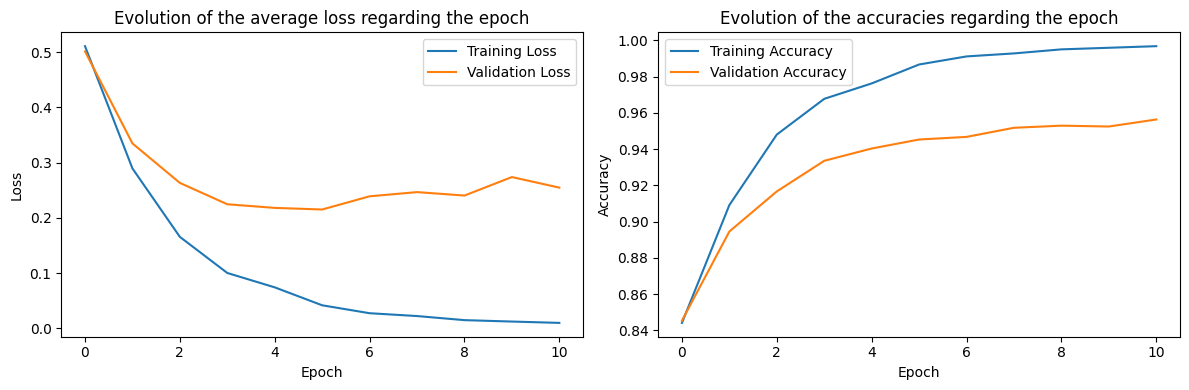

In [ ]:
## Training with self attention
taggerAttention   = NERtagger(trainset,64,128,device='cuda', dropout_prob = 0.5, improvements=["attention"])
res_a, valid_acc_a = taggerAttention.training_loop(trainset,validset,20,32,device='cuda')
plot_train_val_res(res_a)

## Use Part Of Speech Tags as additional inputs


Here we add some functions to get the relevant vocabulary, which is added to the initial entity mappings.

In [ ]:
def get_pos_vocab(filename,padding='<pad>' ,unknown='<unk>'):

    idx2sym = set()

    with open(filename, 'r') as f:
      lines = [line.strip().split(" ") for line in f.readlines() if line.strip() != ""]

    for line in lines :
      idx2sym.add(line[-2])
    idx2sym = list(idx2sym)
    sym2idx = {token: index for index, token in enumerate(idx2sym)}
    if padding:
      idx2sym.append(padding)
      sym2idx[padding]=len(idx2sym)-1
    if unknown:
      idx2sym.append(unknown)
      sym2idx[unknown]=len(idx2sym)-1

    return idx2sym, sym2idx

In [ ]:
def read_conll_pos(conllfilename):
    """
    Reads a CONLL 2003 file and returns a list of sentences.
    A sentence is a list of strings (NER-tags)
    """
    sentences = []
    with open(conllfilename, 'r') as file:
        current_sentence = []
        for line in file:
            line = line.strip()
            if line:
                parts = line.split()
                current_sentence.append(parts[1])  # POS-Tag is the fourth column
            else:
                if current_sentence:
                    sentences.append(current_sentence)
                current_sentence = []
        if current_sentence:
            sentences.append(current_sentence)
    return sentences

In [ ]:
## Test
# Read tokens and NER tags from the dataset
tokens_sentences = read_conll_tokens("eng.testa")
tags_sentences = read_conll_tags("eng.testa")
pos_sentences=read_conll_pos('eng.testa')

# Print the first few sentences for tokens and NER tags
for i in range(5):
    print(f"Sentence {i + 1} - Tokens: {tokens_sentences[i]}")
    print(f"Sentence {i + 1} - NER Tags: {tags_sentences[i]}")
    print(f"Sentence {i + 1} - POS Tags: {pos_sentences[i]}")
    print()

Sentence 1 - Tokens: ['-DOCSTART-']
Sentence 1 - NER Tags: ['O']
Sentence 1 - POS Tags: ['-X-']

Sentence 2 - Tokens: ['CRICKET', '-', 'LEICESTERSHIRE', 'TAKE', 'OVER', 'AT', 'TOP', 'AFTER', 'INNINGS', 'VICTORY', '.']
Sentence 2 - NER Tags: ['O', 'O', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Sentence 2 - POS Tags: ['NNP', ':', 'NNP', 'NNP', 'IN', 'NNP', 'NNP', 'NNP', 'NNP', 'NN', '.']

Sentence 3 - Tokens: ['LONDON', '1996-08-30']
Sentence 3 - NER Tags: ['I-LOC', 'O']
Sentence 3 - POS Tags: ['NNP', 'CD']

Sentence 4 - Tokens: ['West', 'Indian', 'all-rounder', 'Phil', 'Simmons', 'took', 'four', 'for', '38', 'on', 'Friday', 'as', 'Leicestershire', 'beat', 'Somerset', 'by', 'an', 'innings', 'and', '39', 'runs', 'in', 'two', 'days', 'to', 'take', 'over', 'at', 'the', 'head', 'of', 'the', 'county', 'championship', '.']
Sentence 4 - NER Tags: ['I-MISC', 'I-MISC', 'O', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-ORG', 'O', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

On top of the above added functions, the following training implies changes in the NERtagger which are specified with the mention "pos".

Epoch 1
[train] mean Loss = 0.520417 | mean accurracy = 0.828509
[dev] mean Loss = 0.524279 | mean accurracy = 0.828520
Epoch 2
[train] mean Loss = 0.300977 | mean accurracy = 0.903697
[dev] mean Loss = 0.361472 | mean accurracy = 0.879230
Epoch 3
[train] mean Loss = 0.178743 | mean accurracy = 0.943803
[dev] mean Loss = 0.271174 | mean accurracy = 0.912352
Epoch 4
[train] mean Loss = 0.113575 | mean accurracy = 0.963360
[dev] mean Loss = 0.225105 | mean accurracy = 0.929466
Epoch 5
[train] mean Loss = 0.079295 | mean accurracy = 0.974695
[dev] mean Loss = 0.189801 | mean accurracy = 0.939795
Epoch 6
[train] mean Loss = 0.047258 | mean accurracy = 0.985035
[dev] mean Loss = 0.166259 | mean accurracy = 0.949273
Epoch 7
[train] mean Loss = 0.032879 | mean accurracy = 0.989208
[dev] mean Loss = 0.157128 | mean accurracy = 0.950671
Epoch 8
[train] mean Loss = 0.022226 | mean accurracy = 0.992781
[dev] mean Loss = 0.161656 | mean accurracy = 0.951379
Epoch 9
[train] mean Loss = 0.017644 | m

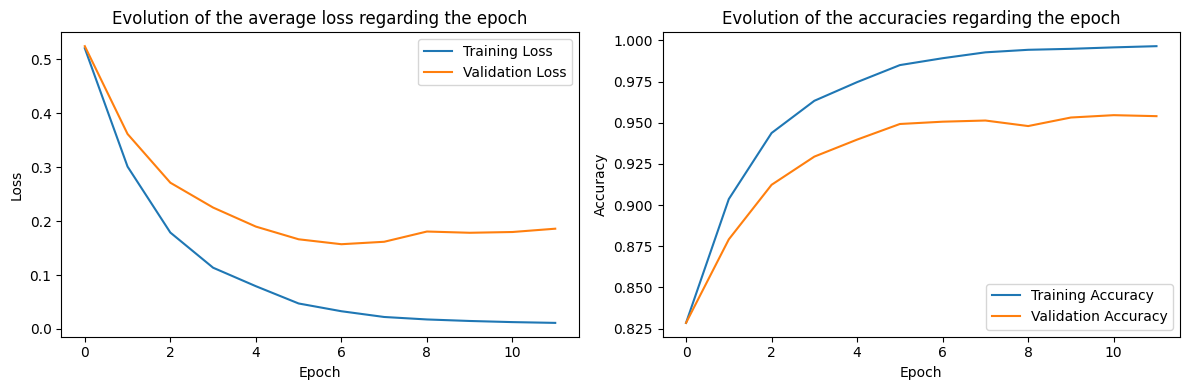

In [ ]:
## Training with pos embedddings
trainsetPOS = DataGenerator('eng.train',pos=True)
validsetPOS = DataGenerator('eng.testa',parentgenerator = trainsetPOS,pos=True)
taggerPOS   = NERtagger(trainsetPOS,64,128,pos_embedding_size=64,device='cuda', dropout_prob = 0.5, improvements=["pos"])
res_pos, valid_acc_pos = taggerPOS.training_loop(trainsetPOS,validsetPOS,20,32,device='cuda')
plot_train_val_res(res_pos)

# Find a way to learn a word embedding for unknown words/ Using pretrained embeddings


**First idea:** use pretrained embeddings (like fasttext) to get embeddings even for unknown words. FastTest uses character n-grams to create subword embeddings, making it effective for handling unknown words.

"One of the key features of fastText word representation is its ability to produce vectors for any words, even made-up ones. Indeed, fastText word vectors are built from vectors of substrings of characters contained in it. This allows to build vectors even for misspelled words or concatenation of words." (https://fasttext.cc/docs/en/faqs.html)



In [ ]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!sudo pip install .
%cd ..

fatal: destination path 'fastText' already exists and is not an empty directory.
/content/fastText
Processing /content/fastText
  Preparing metadata (setup.py) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4290347 sha256=1fdef6a314b5d3183d9a9bfd13f704c40286554fa1706639d0269e58a64e3396
  Stored in directory: /tmp/pip-ephem-wheel-cache-ulwlklr0/wheels/8b/05/af/3cfae069d904597d44b309c956601b611bdf8967bcbe968903
Successfully built fasttext
  Attempting uninstall: fasttext
    Found existing installation: fasttext 0.9.2
    Uninstalling fasttext-0.9.2:
      Successfully uninstalled fasttext-0.9.2
/content


In [ ]:
import fasttext

In [ ]:
%%time
print("This should take ~2 min…")
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

This should take ~2 min…
--2023-11-03 11:26:18--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.111, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz.1’

cc.en.300.bin.gz.1  100%[===================>]   4.19G   198MB/s    in 28s     

2023-11-03 11:26:46 (155 MB/s) - ‘cc.en.300.bin.gz.1’ saved [4503593528/4503593528]

CPU times: user 341 ms, sys: 79.6 ms, total: 421 ms
Wall time: 27.9 s


In [ ]:
%%time
# https://fasttext.cc/docs/en/crawl-vectors.html
import fasttext.util
print("This should take ~2 min…")
fasttext.util.download_model('en', if_exists='ignore') # English
ft = fasttext.load_model('cc.en.300.bin')

This should take ~2 min…
CPU times: user 3.58 s, sys: 6.12 s, total: 9.7 s
Wall time: 35.9 s


In [ ]:
import numpy as np
def create_embedding_matrix(encoding_map,embedding_dim):
  embedding_matrix= np.zeros((len(encoding_map),embedding_dim))
  for word,idx in encoding_map.items():
    embedding_matrix[idx]=ft.get_word_vector(word)

  return torch.from_numpy(embedding_matrix)

On top of the above added functions, the following training implies changes in the NERtagger which are specified with the mention "pretrained".

Epoch 1
[train] mean Loss = 0.243236 | mean accurracy = 0.939026
[dev] mean Loss = 0.267071 | mean accurracy = 0.931538
Epoch 2
[train] mean Loss = 0.120217 | mean accurracy = 0.965007
[dev] mean Loss = 0.202463 | mean accurracy = 0.948049
Epoch 3
[train] mean Loss = 0.083452 | mean accurracy = 0.975911
[dev] mean Loss = 0.181878 | mean accurracy = 0.955630
Epoch 4
[train] mean Loss = 0.063254 | mean accurracy = 0.981604
[dev] mean Loss = 0.160787 | mean accurracy = 0.960597
Epoch 5
[train] mean Loss = 0.049604 | mean accurracy = 0.985165
[dev] mean Loss = 0.150854 | mean accurracy = 0.961030
Epoch 6
[train] mean Loss = 0.038948 | mean accurracy = 0.988189
[dev] mean Loss = 0.135523 | mean accurracy = 0.965667
Epoch 7
[train] mean Loss = 0.025981 | mean accurracy = 0.992220
[dev] mean Loss = 0.134083 | mean accurracy = 0.967382
Epoch 8
[train] mean Loss = 0.021217 | mean accurracy = 0.993395
[dev] mean Loss = 0.155745 | mean accurracy = 0.966709
Epoch 9
[train] mean Loss = 0.017132 | m

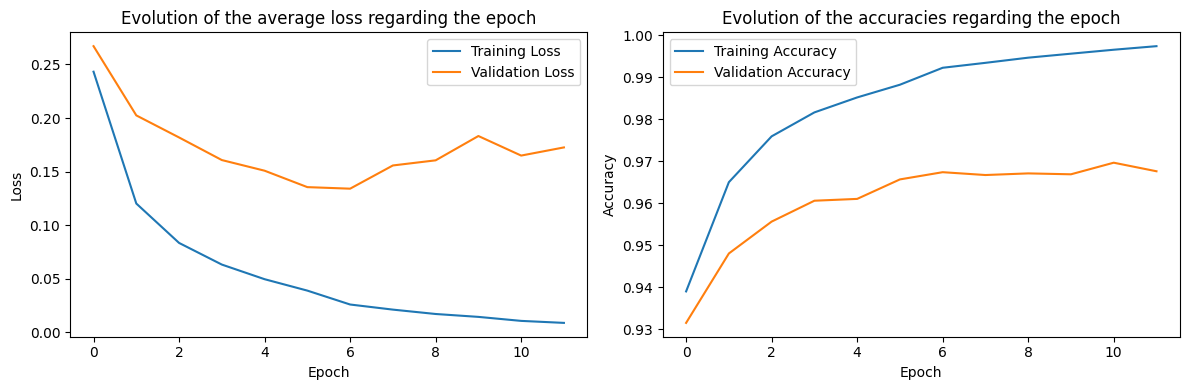

In [ ]:
#Training with pretrained word embeddings from FastText
trainset = DataGenerator('eng.train')
validset = DataGenerator('eng.testa',parentgenerator = trainset)
taggerUNK = NERtagger(traingenerator=trainset, embedding_size=300, hidden_size=128,device='cuda', early_stopping_patience=5,pos_embedding_size=32, dropout_prob = 0.5, improvements=["pretrained"])
res, valid_acc = taggerUNK.training_loop(trainset,validset,20,32,device='cuda')
plot_train_val_res(res)

**Second idea:** Add character-level-embeddings for unknown words. We will break down unknown words into their consitutent characters and create embeddings for those characters. These embeddings are then combined to represent the word as a whole.


**Conclusion:** During implementation we realized that we also had to change the generation of the data to handle unknown word in the test set. Given the time constraints, we have not finished integrating the handling of unknown words. Still, we have implemented the use of FastText embeddings as pretrained embeddings for our model which lead to slightly higher accuracies on the dev set.

## Training with all improvments, i.e. the attention layer, the POS tags and pretrained word embeddings

Epoch 1
[train] mean Loss = 0.502330 | mean accurracy = 0.816948
[dev] mean Loss = 0.486562 | mean accurracy = 0.818267
Epoch 2
[train] mean Loss = 0.479792 | mean accurracy = 0.837604
[dev] mean Loss = 0.451957 | mean accurracy = 0.834874
Epoch 3
[train] mean Loss = 0.486892 | mean accurracy = 0.848560
[dev] mean Loss = 0.455746 | mean accurracy = 0.847749
Epoch 4
[train] mean Loss = 0.486313 | mean accurracy = 0.860775
[dev] mean Loss = 0.455424 | mean accurracy = 0.860587
Epoch 5
[train] mean Loss = 0.401065 | mean accurracy = 0.876877
[dev] mean Loss = 0.386335 | mean accurracy = 0.875194
Epoch 6
[train] mean Loss = 0.313344 | mean accurracy = 0.903400
[dev] mean Loss = 0.318600 | mean accurracy = 0.896881
Epoch 7
[train] mean Loss = 0.239560 | mean accurracy = 0.923876
[dev] mean Loss = 0.260991 | mean accurracy = 0.918565
Epoch 8
[train] mean Loss = 0.215147 | mean accurracy = 0.931526
[dev] mean Loss = 0.258562 | mean accurracy = 0.917962
Epoch 9
[train] mean Loss = 0.175528 | m

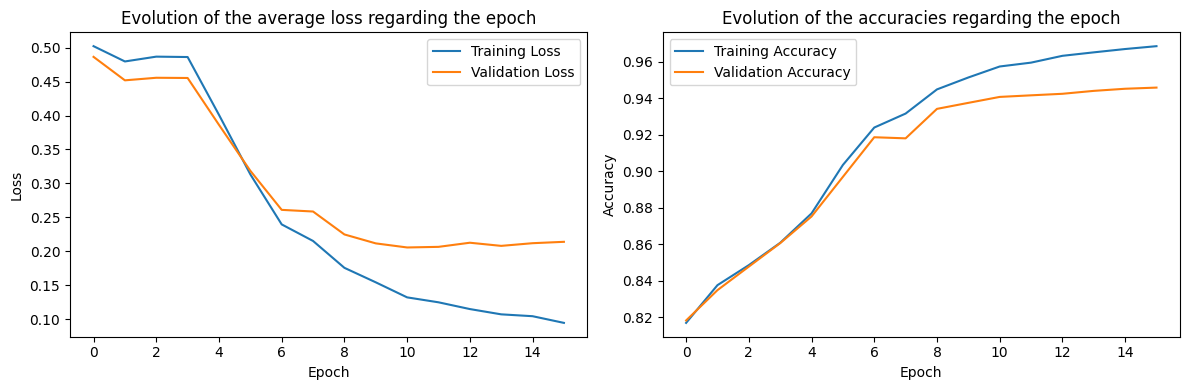

In [ ]:
## Training with self attention, pos embeddings and pretrained embeddings
# When using pretrained embeddings, the embedding dimension must be 300 because reducing the FastText embeddings is too costly
taggerPOSAttentionPretrained   = NERtagger(trainsetPOS,300,128,pos_embedding_size=64,device='cuda', dropout_prob = 0.5, improvements=["attention","pos","pretrained"])
res_pos_a_pre, valid_acc_pos_a_pre = taggerPOSAttentionPretrained.training_loop(trainsetPOS,validsetPOS,20,32,device='cuda')
plot_train_val_res(res_pos_a_pre)

# Random search
In order to get closer to the accuracy obtained on the trainset, we have performed a final random search. The obtained results were not as concluant as the one obtained with the previously implemented improvements. Thus, we decided not to proceed further with this exploration.

In [ ]:
from tqdm import tqdm
import random
from itertools import product

# Define the hyperparameter search space

random_search={
    'learning_rate': [0.001,0.005,0.01,0.04],
    'pos_embedding_size':[50,150],
    'embedding_size':[150,200]
}


# Define the number of random configurations to try
num_configs = 30
best_uas = 0
best_config = None
configurations_scores=list()
nb_epochs= 10

with open('/content/drive/MyDrive/ML for NLP3/TPs Crabbé/RandomSearch.tsv','a') as file:   # /content/drive/MyDrive/TP4/RandomSearch.tsv


  # Perform random search
  with tqdm(total=num_configs,desc='Computing Random search') as pbar:
    for i in range(num_configs):
        # Randomly sample a configuration
        config = {param: random.choice(values) for param, values in random_search.items()}
        print(f" Next configuration is configuration {i+1}/{num_configs} : {config}")

        print(f"\nconfig: learning_rate:{config['learning_rate']},pos embedding size:{config['pos_embedding_size']},embedding_size:{config['embedding_size']}")
        model= NERtagger(traingenerator=trainsetPOS,embedding_size= config['embedding_size'],hidden_size= 50,pos_embedding_size=config['pos_embedding_size'], device='cuda', improvements=["attention","pos"])
        _,valid_acc=model.training_loop(traingenerator=trainsetPOS,validgenerator=validsetPOS, epochs=nb_epochs, batch_size= 64, learning_rate=config['learning_rate'], device='cuda')

        min_loss=model.minloss

        print(f"Min loss on configuration {i}/{num_configs} is {min_loss}, accuracy on dev is {valid_acc}")


        file.write(f"{config['learning_rate']}\t{config['pos_embedding_size']}\t{config['embedding_size']}\t{min_loss}\t{valid_acc}\n")
        pbar.update(1)

Computing Random search:   0%|          | 0/30 [00:00<?, ?it/s]

 Next configuration is configuration 1/30 : {'learning_rate': 0.04, 'pos_embedding_size': 150, 'embedding_size': 150}

config: learning_rate:0.04,pos embedding size:150,embedding_size:150
Epoch 1
[train] mean Loss = 0.290257 | mean accurracy = 0.897003
[dev] mean Loss = 0.337289 | mean accurracy = 0.889443
Epoch 2
[train] mean Loss = 0.237975 | mean accurracy = 0.919960
[dev] mean Loss = 0.323347 | mean accurracy = 0.874914
Epoch 3
[train] mean Loss = 0.270340 | mean accurracy = 0.905077
[dev] mean Loss = 0.315404 | mean accurracy = 0.898432
Epoch 4
[train] mean Loss = 0.369930 | mean accurracy = 0.876345
[dev] mean Loss = 0.375419 | mean accurracy = 0.849146
Epoch 5
[train] mean Loss = 0.363920 | mean accurracy = 0.886402
[dev] mean Loss = 0.479801 | mean accurracy = 0.841741
Epoch 6
[train] mean Loss = 0.409447 | mean accurracy = 0.878047
[dev] mean Loss = 0.471523 | mean accurracy = 0.837940
Epoch 7
[train] mean Loss = 0.392226 | mean accurracy = 0.886145
[dev] mean Loss = 0.508318 

Computing Random search:   3%|▎         | 1/30 [05:54<2:51:24, 354.64s/it]

[dev] mean Loss = 0.431156 | mean accurracy = 0.826477
Early stopping. No improvement for the last 5 epochs.
Min loss on configuration 0/30 is 0.31540351671536954, accuracy on dev is 0.8264770317216148
 Next configuration is configuration 2/30 : {'learning_rate': 0.001, 'pos_embedding_size': 50, 'embedding_size': 150}

config: learning_rate:0.001,pos embedding size:50,embedding_size:150
Epoch 1
[train] mean Loss = 0.595080 | mean accurracy = 0.808274
[dev] mean Loss = 0.574203 | mean accurracy = 0.813821
Epoch 2
[train] mean Loss = 0.293063 | mean accurracy = 0.907206
[dev] mean Loss = 0.355832 | mean accurracy = 0.873100
Epoch 3
[train] mean Loss = 0.159676 | mean accurracy = 0.950004
[dev] mean Loss = 0.300501 | mean accurracy = 0.891281
Epoch 4
[train] mean Loss = 0.095150 | mean accurracy = 0.970830
[dev] mean Loss = 0.265239 | mean accurracy = 0.908283
Epoch 5
[train] mean Loss = 0.067719 | mean accurracy = 0.978957
[dev] mean Loss = 0.227471 | mean accurracy = 0.922086
Epoch 6
[t

Computing Random search:   7%|▋         | 2/30 [14:04<3:22:43, 434.40s/it]

[dev] mean Loss = 0.250232 | mean accurracy = 0.933900
Min loss on configuration 1/30 is 0.19898718317003095, accuracy on dev is 0.93390037363657
 Next configuration is configuration 3/30 : {'learning_rate': 0.01, 'pos_embedding_size': 50, 'embedding_size': 150}

config: learning_rate:0.01,pos embedding size:50,embedding_size:150
Epoch 1
[train] mean Loss = 0.229321 | mean accurracy = 0.925945
[dev] mean Loss = 0.356923 | mean accurracy = 0.870972
Epoch 2
[train] mean Loss = 0.106713 | mean accurracy = 0.967278
[dev] mean Loss = 0.301554 | mean accurracy = 0.889063
Epoch 3
[train] mean Loss = 0.081542 | mean accurracy = 0.974276
[dev] mean Loss = 0.302833 | mean accurracy = 0.896128
Epoch 4
[train] mean Loss = 0.087990 | mean accurracy = 0.973440
[dev] mean Loss = 0.349941 | mean accurracy = 0.903852
Epoch 5
[train] mean Loss = 0.103303 | mean accurracy = 0.967426
[dev] mean Loss = 0.345965 | mean accurracy = 0.898259
Epoch 6
[train] mean Loss = 0.089571 | mean accurracy = 0.972092
[de

Computing Random search:  10%|█         | 3/30 [22:13<3:26:39, 459.25s/it]

[dev] mean Loss = 0.356411 | mean accurracy = 0.904234
Min loss on configuration 2/30 is 0.26106299108839104, accuracy on dev is 0.9042338389987883
 Next configuration is configuration 4/30 : {'learning_rate': 0.04, 'pos_embedding_size': 150, 'embedding_size': 200}

config: learning_rate:0.04,pos embedding size:150,embedding_size:200
Epoch 1
[train] mean Loss = 0.258327 | mean accurracy = 0.902655
[dev] mean Loss = 0.322700 | mean accurracy = 0.890995
Epoch 2
[train] mean Loss = 0.241711 | mean accurracy = 0.913777
[dev] mean Loss = 0.283752 | mean accurracy = 0.907782
Epoch 3
[train] mean Loss = 0.247698 | mean accurracy = 0.916422
[dev] mean Loss = 0.278548 | mean accurracy = 0.911132
Epoch 4
[train] mean Loss = 0.270793 | mean accurracy = 0.909205
[dev] mean Loss = 0.377662 | mean accurracy = 0.862445
Epoch 5
[train] mean Loss = 0.332392 | mean accurracy = 0.884119
[dev] mean Loss = 0.411416 | mean accurracy = 0.865582
Epoch 6
[train] mean Loss = 0.319989 | mean accurracy = 0.897758

Computing Random search:  13%|█▎        | 4/30 [28:35<3:05:40, 428.48s/it]

[dev] mean Loss = 0.456936 | mean accurracy = 0.880088
Early stopping. No improvement for the last 5 epochs.
Min loss on configuration 3/30 is 0.27854839587387714, accuracy on dev is 0.8800882886567292
 Next configuration is configuration 5/30 : {'learning_rate': 0.005, 'pos_embedding_size': 50, 'embedding_size': 150}

config: learning_rate:0.005,pos embedding size:50,embedding_size:150
Epoch 1
[train] mean Loss = 0.304026 | mean accurracy = 0.900503
[dev] mean Loss = 0.320279 | mean accurracy = 0.896985
Epoch 2
[train] mean Loss = 0.110244 | mean accurracy = 0.967102
[dev] mean Loss = 0.204298 | mean accurracy = 0.930936
Epoch 3
[train] mean Loss = 0.058709 | mean accurracy = 0.983176
[dev] mean Loss = 0.182567 | mean accurracy = 0.943105
Epoch 4
[train] mean Loss = 0.052927 | mean accurracy = 0.984184
[dev] mean Loss = 0.158431 | mean accurracy = 0.954605
Epoch 5
[train] mean Loss = 0.058834 | mean accurracy = 0.982088
[dev] mean Loss = 0.239096 | mean accurracy = 0.921058
Epoch 6
[t

Computing Random search:  17%|█▋        | 5/30 [35:36<2:57:27, 425.91s/it]

[dev] mean Loss = 0.200813 | mean accurracy = 0.938330
Early stopping. No improvement for the last 5 epochs.
Min loss on configuration 4/30 is 0.15843146095923644, accuracy on dev is 0.9383295535845443
 Next configuration is configuration 6/30 : {'learning_rate': 0.001, 'pos_embedding_size': 50, 'embedding_size': 200}

config: learning_rate:0.001,pos embedding size:50,embedding_size:200
Epoch 1
[train] mean Loss = 0.563034 | mean accurracy = 0.812736
[dev] mean Loss = 0.606038 | mean accurracy = 0.804826
Epoch 2
[train] mean Loss = 0.252170 | mean accurracy = 0.923424
[dev] mean Loss = 0.406409 | mean accurracy = 0.902927
Epoch 3
[train] mean Loss = 0.127069 | mean accurracy = 0.962744
[dev] mean Loss = 0.355072 | mean accurracy = 0.930048
Epoch 4
[train] mean Loss = 0.074874 | mean accurracy = 0.978430
[dev] mean Loss = 0.356274 | mean accurracy = 0.938708
Epoch 5
[train] mean Loss = 0.055433 | mean accurracy = 0.983588
[dev] mean Loss = 0.375204 | mean accurracy = 0.943179
Epoch 6
[t

Computing Random search:  20%|██        | 6/30 [42:00<2:44:39, 411.66s/it]

[dev] mean Loss = 0.461637 | mean accurracy = 0.949433
Early stopping. No improvement for the last 5 epochs.
Min loss on configuration 5/30 is 0.3550715032249424, accuracy on dev is 0.9494329449742978
 Next configuration is configuration 7/30 : {'learning_rate': 0.01, 'pos_embedding_size': 50, 'embedding_size': 150}

config: learning_rate:0.01,pos embedding size:50,embedding_size:150
Epoch 1
[train] mean Loss = 0.238076 | mean accurracy = 0.920492
[dev] mean Loss = 0.263406 | mean accurracy = 0.911567
Epoch 2
[train] mean Loss = 0.098618 | mean accurracy = 0.968777
[dev] mean Loss = 0.184510 | mean accurracy = 0.937139
Epoch 3
[train] mean Loss = 0.081296 | mean accurracy = 0.974715
[dev] mean Loss = 0.214571 | mean accurracy = 0.922733
Epoch 4
[train] mean Loss = 0.085329 | mean accurracy = 0.973505
[dev] mean Loss = 0.192463 | mean accurracy = 0.938053
Epoch 5
[train] mean Loss = 0.091737 | mean accurracy = 0.972126
[dev] mean Loss = 0.196650 | mean accurracy = 0.940845
Epoch 6
[trai

Computing Random search:  23%|██▎       | 7/30 [46:43<2:21:44, 369.78s/it]

[dev] mean Loss = 0.245169 | mean accurracy = 0.923034
Early stopping. No improvement for the last 5 epochs.
Min loss on configuration 6/30 is 0.18450971779445224, accuracy on dev is 0.9230344233595814
 Next configuration is configuration 8/30 : {'learning_rate': 0.005, 'pos_embedding_size': 150, 'embedding_size': 200}

config: learning_rate:0.005,pos embedding size:150,embedding_size:200
Epoch 1
[train] mean Loss = 0.343904 | mean accurracy = 0.882210
[dev] mean Loss = 0.342946 | mean accurracy = 0.893407
Epoch 2
[train] mean Loss = 0.113844 | mean accurracy = 0.964670
[dev] mean Loss = 0.197190 | mean accurracy = 0.935309
Epoch 3
[train] mean Loss = 0.061871 | mean accurracy = 0.981373
[dev] mean Loss = 0.176951 | mean accurracy = 0.950004
Epoch 4
[train] mean Loss = 0.057385 | mean accurracy = 0.983316
[dev] mean Loss = 0.172959 | mean accurracy = 0.948785
Epoch 5
[train] mean Loss = 0.057308 | mean accurracy = 0.983073
[dev] mean Loss = 0.211545 | mean accurracy = 0.943527
Epoch 6


Computing Random search:  27%|██▋       | 8/30 [54:23<2:26:05, 398.45s/it]

[dev] mean Loss = 0.229880 | mean accurracy = 0.919229
Early stopping. No improvement for the last 5 epochs.
Min loss on configuration 7/30 is 0.17295887492057374, accuracy on dev is 0.9192286470797959
 Next configuration is configuration 9/30 : {'learning_rate': 0.005, 'pos_embedding_size': 50, 'embedding_size': 150}

config: learning_rate:0.005,pos embedding size:50,embedding_size:150
Epoch 1
[train] mean Loss = 0.311440 | mean accurracy = 0.896072
[dev] mean Loss = 0.367025 | mean accurracy = 0.872506
Epoch 2
[train] mean Loss = 0.105489 | mean accurracy = 0.969000
[dev] mean Loss = 0.277013 | mean accurracy = 0.898466
Epoch 3
[train] mean Loss = 0.060483 | mean accurracy = 0.982097
[dev] mean Loss = 0.311552 | mean accurracy = 0.899077
Epoch 4
[train] mean Loss = 0.053599 | mean accurracy = 0.983798
[dev] mean Loss = 0.303585 | mean accurracy = 0.900859
Epoch 5
[train] mean Loss = 0.056546 | mean accurracy = 0.983103
[dev] mean Loss = 0.392871 | mean accurracy = 0.895981
Epoch 6
[t

Computing Random search:  30%|███       | 9/30 [59:14<2:07:40, 364.78s/it]

[dev] mean Loss = 0.385587 | mean accurracy = 0.895536
Early stopping. No improvement for the last 5 epochs.
Min loss on configuration 8/30 is 0.27701326674770294, accuracy on dev is 0.8955359686334252
 Next configuration is configuration 10/30 : {'learning_rate': 0.005, 'pos_embedding_size': 50, 'embedding_size': 150}

config: learning_rate:0.005,pos embedding size:50,embedding_size:150
Epoch 1
[train] mean Loss = 0.316384 | mean accurracy = 0.895884
[dev] mean Loss = 0.351014 | mean accurracy = 0.891990
Epoch 2
[train] mean Loss = 0.116202 | mean accurracy = 0.964544
[dev] mean Loss = 0.191186 | mean accurracy = 0.937188
Epoch 3
[train] mean Loss = 0.065258 | mean accurracy = 0.980558
[dev] mean Loss = 0.188473 | mean accurracy = 0.941297


Computing Random search:  30%|███       | 9/30 [59:57<2:19:55, 399.77s/it]


KeyboardInterrupt: ignored

# Conclusion

After adding ameliorations to the initial NER Tagger (POS embeddings, Attention Layer, pretrained word embeddings) we found that adding pretrained word embeddings was the most improving  (dev accuracy = 0.967). Adding POS embeddings and an attention layer individually showed increase accuracy on the dev set up to 0.956 while before we obtained accuracies under 0.951. However, training with all improvements simultaneously did decrease the dev accuracy to 0.945 but showed less overfitting.

Further, we explored the following improvement:
* Adding Convolution to the NER Tagger (on word and character level)
* Embeddings for unknown words in the test set.

However, we found out that such changes involved rethinking the architecture of multiple classes and functions (i.e., DataGenerator, vocabulary functions, encoding functions). Due to times constraints, both of these implementations have not been completely carried out.

